In [1]:
# Ivan Morozov & Tim Zolkin, 2024

In [2]:
# !pip install numpy
# !pip install numba

# # (optional)

# !pip install tbb
# !conda install intel-cmplr-lib-rt

In [3]:
# How to load numpy array to Wolfram Mathematica (flatten numpy array before export)

# size = 5001 ;
# data = ArrayReshape[BinaryReadList["test.dat", "Real64"], {size, size}] ;
# data // Dimensions

In [4]:
import numpy
import numba

from matplotlib import pyplot as plt
from matplotlib import colormaps

fastmath:bool=True
parallel:bool=True

# Maps (python & numba.jit)

In [5]:
# Note, all mappings are assumed to have Tuple((float64[:], float64[:]))(float64, float64[:], float64[:]) signatures
# With one parameter (float64), input array of initial coordinates (float64[:]) and momenta (float64[:])
# The result is a tuple of output coordinates (float64[:]) and momenta (float64[:])

@numba.jit('Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])', nopython=True, fastmath=fastmath)
def quadratic_forward(w, q, p):
    return p, -q + w*p + p**2

@numba.jit('Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])', nopython=True, fastmath=fastmath)
def quadratic_inverse(w, q, p):
    return -p + w*q + q**2, q

@numba.jit('Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])', nopython=True, fastmath=fastmath)
def cubic_positive_forward(w, q, p):
    return p, -q + w*p + p**3

@numba.jit('Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])', nopython=True, fastmath=fastmath)
def cubic_positive_inverse(w, q, p):
    return -p + w*q + q**3, q

@numba.jit('Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])', nopython=True, fastmath=fastmath)
def cubic_negative_forward(w, q, p):
    return p, -q + w*p - p**3

@numba.jit('Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])', nopython=True, fastmath=fastmath)
def cubic_negative_inverse(w, q, p):
    return -p + w*q - q**3, q

@numba.jit('Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])', nopython=True, fastmath=fastmath)
def chirikov_forward(w, q, p):
    return p % (2.0*numpy.pi), (-q + 2.0*p + w*numpy.sin(p)) % (2.0*numpy.pi)

@numba.jit('Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])', nopython=True, fastmath=fastmath)
def chirikov_inverse(w, q, p):
    return (-p + 2.0*q + w*numpy.sin(q)) % (2.0*numpy.pi), q % (2.0*numpy.pi)

# Lines

In [6]:
# Note, all functions are assumed to have float64[:](float64, float64[:]) signatuires
# With one parameter (float64) and input array of coordinates (float64[:])
# The result is a array of input momenta float64[:]

# QUADRATIC/SEXTUPOLE (FRACTAL)
# (Q, P) -> (P,- Q + W P + P^2)
# a: W [-3.0,2.0], Q [-1.25,1.75], P = Q
# b: W [-3.0,2.0], Q [-1.25,1.75], P = (W Q + Q^2)/2

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def quadratic_line_a(w, q):
    return q

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def quadratic_line_b(w, q):
    return 0.5*(w*q + q**2)

# CUBIC-POSITIVE/OCTUPOLE (FRACTAL)
# (Q, P) -> (P,- Q + W P + P^3)
# 1: W [-5.0,2.0], Q [0.0,2.0], P = Q
# 2: W [-5.0,2.0], Q [0.0,2.0], P = (W Q + Q^3)/2
# 3: W [-5.0,2.0], Q [0.0,2.0], P = -Q
# 4: W [-5.0,2.0], Q = 0, P = [0.0,2.0]

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def cubic_positive_line_a(w, q):
    return q

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def cubic_positive_line_b(w, q):
    return 0.5*(w*q + q**3)

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def cubic_positive_line_c(w, q):
    return -q

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def cubic_positive_line_d(w, q):
    return numpy.linspace(0.0, 2.0, len(q))
    
# CUBIC-NEGATIVE/OCTUPOLE (FRACTAL)
# (Q, P) -> (P,- Q + W P - P^3)
#1: W [-2.0,5.0], Q [0.0,2.0], P = Q
#2: W [-2.0,5.0], Q [0.0,2.0], P = (W Q - Q^3)/2
#3: W [-2.0,5.0], Q [0.0,2.0], P = -Q
#4: W [-2.0,5.0], Q = 0, P = [0.0, 2.0]

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def cubic_negative_line_a(w, q):
    return q

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def cubic_negative_line_b(w, q):
    return 0.5*(w*q - q**3)

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def cubic_negative_line_c(w, q):
    return -q

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def cubic_negative_line_d(w, q):
    return numpy.linspace(0.0, 2.0, len(q))
    
# CHIRIKOV (FRACTAL)
# (Q, P) -> (P,- Q + 2 P + W Sin[P]) mod 2 Pi
# 1: W [0,3.5 Pi], Q [0.0,Pi], P = Q                 
# 2: W [0,3.5 Pi], Q [0.0,Pi], P = Q + W/2 Sin[Q]
# 3: W [0,3.5 Pi], Q [0.0,Pi], P = -Q + 2 Pi
# 4: W [0,3.5 Pi], Q = Pi, P = [0.0,Pi]
# 5: W [0,3.5 Pi], Q = 0,  P = [0.0,Pi]

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def chirikov_line_a(w, q):
    return q

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def chirikov_line_b(w, q):
    return (q + w/2*numpy.sin(q)) % (2.0*numpy.pi)

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def chirikov_line_c(w, q):
    return (-q + 2*numpy.pi) % (2.0*numpy.pi)

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def chirikov_line_d(w, q):
    return numpy.linspace(0.0, 2.0, len(q))

@numba.jit('float64[:](float64, float64[:])', nopython=True, fastmath=fastmath)
def chirikov_line_e(w, q):
    return numpy.linspace(0.0, 2.0, len(q))

# Orbit

In [7]:
# Note, for output coordinates (float64[:, :]) and momenta (float64[:, :]), the shape is (len(q), n + 1) or (len(p), n + 1)
# Also, len(q) should be equal to len(p) 

# 'Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])'
# 'Tuple((float64[:, :], float64[:, :]))(int64, float64, float64[:], float64[:])'

def orbit_factory(mapping):
    @numba.jit('Tuple((float64[:, :], float64[:, :]))(int64, float64, float64[:], float64[:])', nopython=True, fastmath=fastmath)
    def orbit(n, w, q, p):
        qs = numpy.zeros((n + 1, len(q)))
        ps = numpy.zeros((n + 1, len(p)))
        qs[0], ps[0] = q, p
        for i in range(1, n + 1):
            qs[i], ps[i] = q, p = mapping(w, q, p)
        return qs.T, ps.T
    return orbit

# Frequency

In [8]:
# Use, s=1.0 filter order for Birkhoff averaging

@numba.jit('float64[:](int64, float64)', nopython=True, fastmath=fastmath)
def birkhoff(n, s):
    t = numpy.linspace(0.0, (n - 1.0)/n, n)
    f = numpy.exp(-1.0/((1.0 - t)**s*t**s))
    return f/numpy.sum(f)

@numba.jit('float64[:](float64[:], float64[:, :], float64[:, :])', nopython=True, fastmath=fastmath)
def frequency(f, qs, ps):
    return numpy.sum(numpy.ascontiguousarray(f).reshape(1, -1)*(numpy.diff(numpy.arctan2(qs, ps)) % (2.0*numpy.pi)), axis=1)/(2.0*numpy.pi)

@numba.jit('float64[:, :](float64, float64, float64[:, :])', nopython=True, parallel=parallel, fastmath=fastmath)
def tongues(error, value, table):
    ni, nj = table.shape
    local = numpy.copy(table)
    for i in numba.prange(1, ni):
        for j in numba.prange(1, nj):
            if not numpy.isnan(local[i, j]):
                if numpy.abs(local[i, j] - table[i, j - 1]) <= error:
                    local[i, j] = value
    return local

# REM

In [9]:
# 'Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])'
# 'Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])'
# 'float64[:](float64, float64[:])'
# 'float64[:, :](int64, float64[:], float64[:])'

def rem_factory(forward, inverse, line, *, level=1.0E-16):
    @numba.jit('float64[:, :](int64, float64[:], float64[:])', nopython=True, parallel=parallel, fastmath=fastmath)
    def rem(n, w, q):
        out = numpy.zeros((w.size, q.size))
        for i in numba.prange(w.size):
            p = line(w[i], q)
            Q = q
            P = p
            for _ in range(n):
                Q, P = forward(w[i], Q, P)
            for _ in range(n):
                Q, P = inverse(w[i], Q, P)
            out[i] = numpy.log10(level + numpy.sqrt((q - Q)**2 + (p - P)**2))
        return out 
    return rem

# FMA

In [10]:
# 'Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])'
# 'float64[:](float64, float64[:])'
# 'float64[:, :, :](float64[:], float64[:], float64[:])'

def fma_factory(mapping, line, *, orbit_factory=orbit_factory):
    orbit = orbit_factory(mapping)
    @numba.jit('float64[:, :, :](float64[:], float64[:], float64[:])', nopython=True, parallel=parallel, fastmath=fastmath)
    def fma(f, w, q):
        out = numpy.zeros((w.size, q.size, 1 + 1))
        for i in numba.prange(w.size):
            p = line(w[i], q)
            qs, ps = orbit(len(f), w[i], q, p)
            out[i, :, 0] = frequency(f, qs, ps)
            qs, ps = orbit(len(f), w[i], qs[:, -1], ps[:, -1])
            out[i, :, 1] = frequency(f, qs, ps)
        return out
    return fma

# Example-01: REM & FMA for quadratic mapping

In [11]:
# Set number of iterations
# For REM, first, n iterations are performed forward, next, n iterations are performed backward
# For FMA, 2n iterations are performed, two frequencies are computed using the first and the last halves, respectively

n = 2**12

# Set filter for Birkhoff avereging in frequency computation

f = birkhoff(n, 1.0)

# Set initial grid (parameters and coordinates)

w = numpy.linspace(-3.0, 2.0, 1001)
q = numpy.linspace(-1.5, 1.5, 1001)

In [12]:
# Set REM & FMA

rem = rem_factory(quadratic_forward, quadratic_inverse, quadratic_line_b)
fma = fma_factory(quadratic_forward, quadratic_line_b)

In [13]:
%%time

# Compute REM

out_rem = rem(n, w, q)
out_rem.shape

CPU times: user 4.41 s, sys: 32.6 ms, total: 4.45 s
Wall time: 252 ms


(1001, 1001)

In [14]:
%%time

# Compute FMA

out_fma = fma(f, w, q)
out_fma.shape

CPU times: user 8min, sys: 47.8 s, total: 8min 48s
Wall time: 25.8 s


(1001, 1001, 2)

1002001
309306


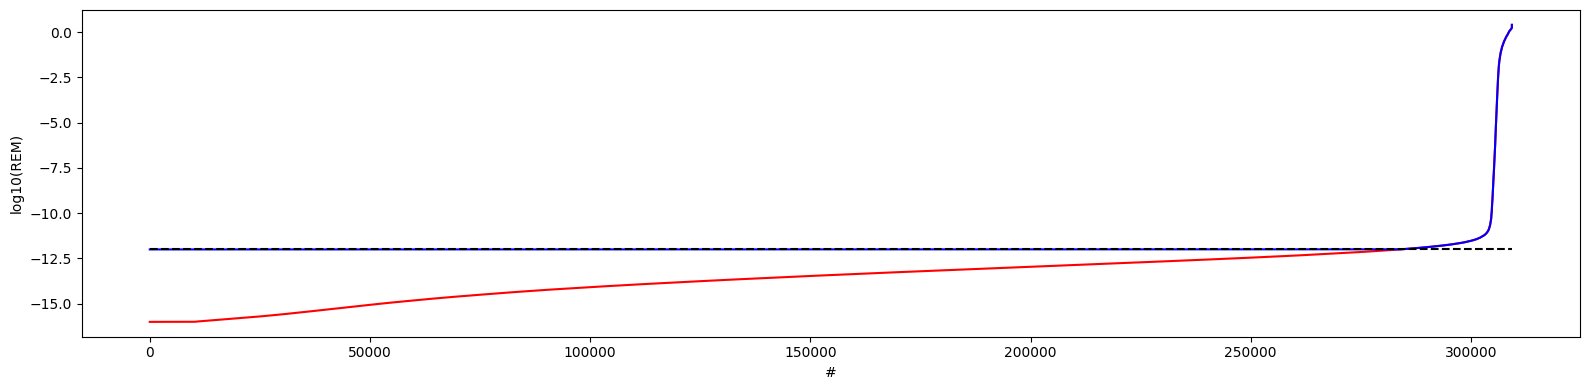

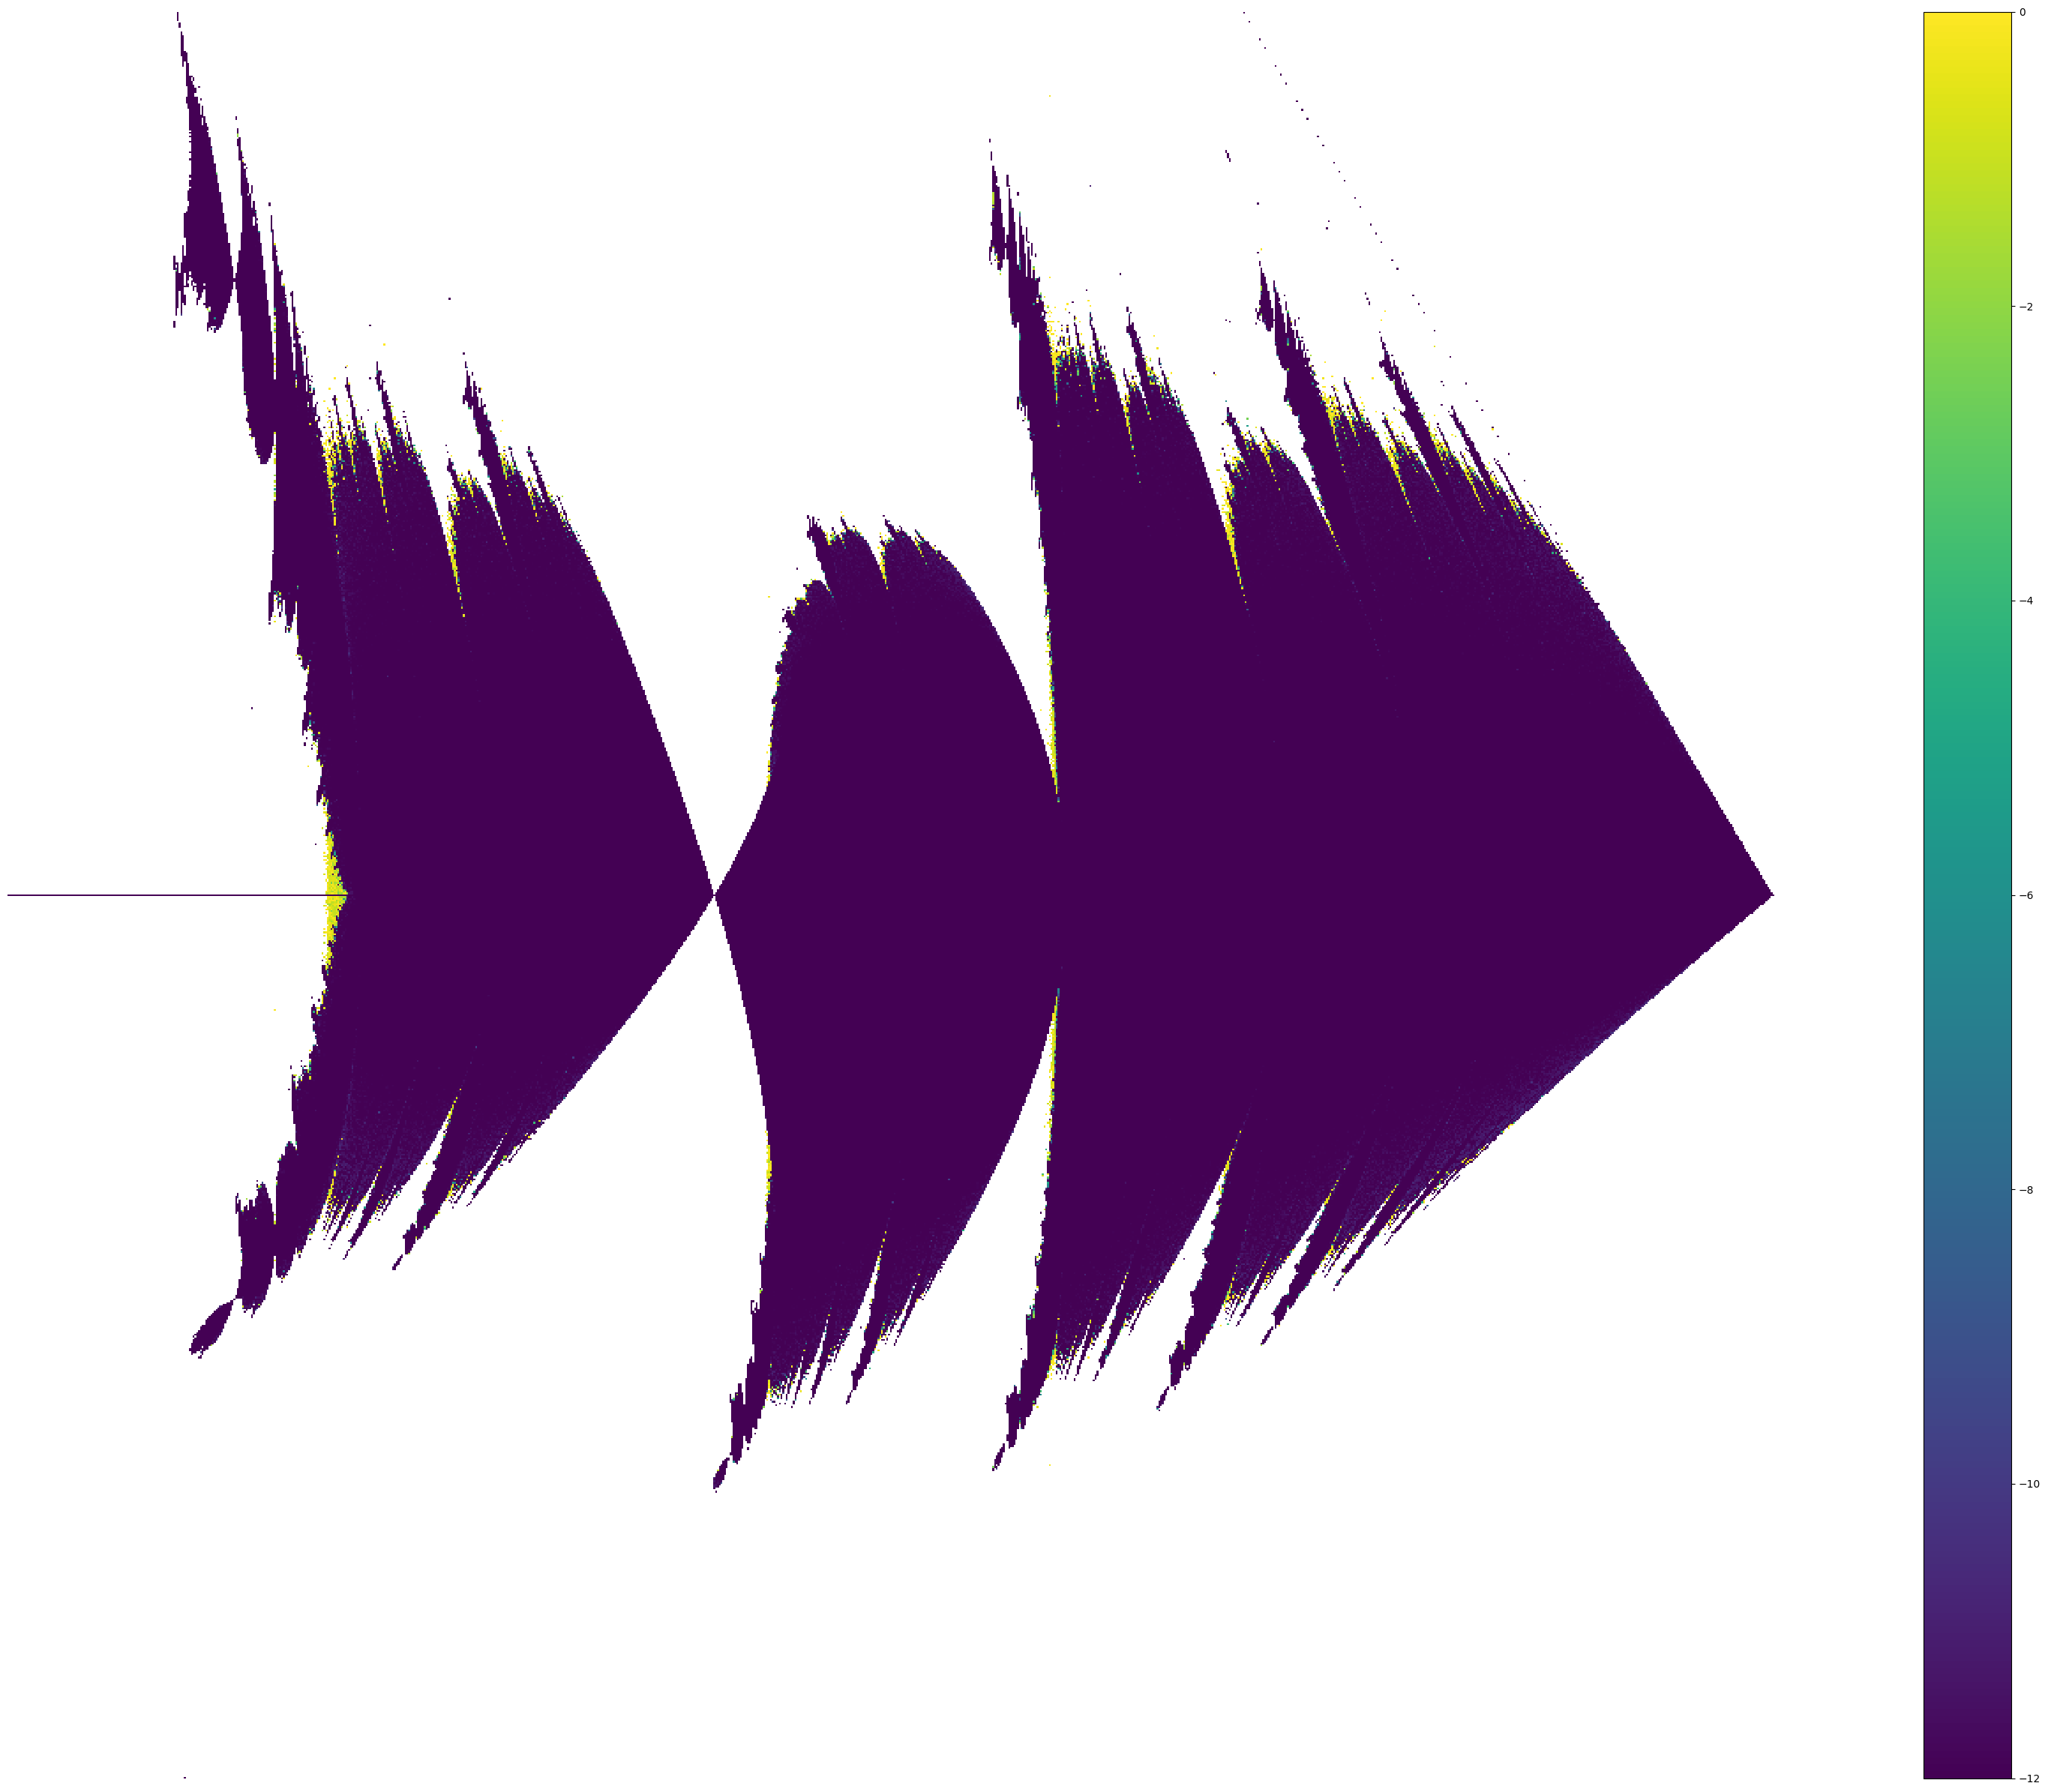

In [15]:
# Plot & save REM results

# Note, REM results contains 'nan's for 'escaped' initials
# Use numpy.nan_to_num befor export if 'nan's are not desirable

# Set output file nane

rem_file = 'rem.dat'

# Sorted REM values

elbow = numpy.nan_to_num(out_rem.flatten(), nan=100.0)
print(len(elbow))

# Remove replaced nan values

elbow = elbow[elbow!= 100.0]
print(len(elbow))

# Plot elbow

# Note, this elbow can be used to define color range, since elbow location separetes regular from chaotic
# Here, all values less than -12.0 are winsorized to -12.0

plt.figure(figsize=(16, 4))
plt.plot(numpy.sort(elbow), color='red')
elbow[elbow <= -12.0] = -12.0
plt.plot(numpy.sort(elbow), color='blue')
plt.xlabel('#')
plt.ylabel('log10(REM)')
plt.hlines(-12.0, 0, len(elbow), color='black', linestyles='dashed')
plt.tight_layout()
plt.savefig('rem_elbow.png', dpi=200)
plt.show()

# Plot REM color plot

# Winsorize data

out = numpy.nan_to_num(out_rem, nan=100.0)
out[out <= -12.0] = -12.0
out[out == 100.0] = -100.0
out[out >= 0.0] = 0.0
out[out == -100.0] = float('nan')

plt.figure(figsize=(5*8, 3*8))
plt.imshow(out.T, vmin=-12.0, vmax=0.0, aspect='equal', origin='lower', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.savefig('rem.png', dpi=200)
plt.show()

# Save data

nan = 1.0
out = numpy.nan_to_num(out_rem.T.flatten(), nan=nan)
out.astype('float64').tofile(rem_file)

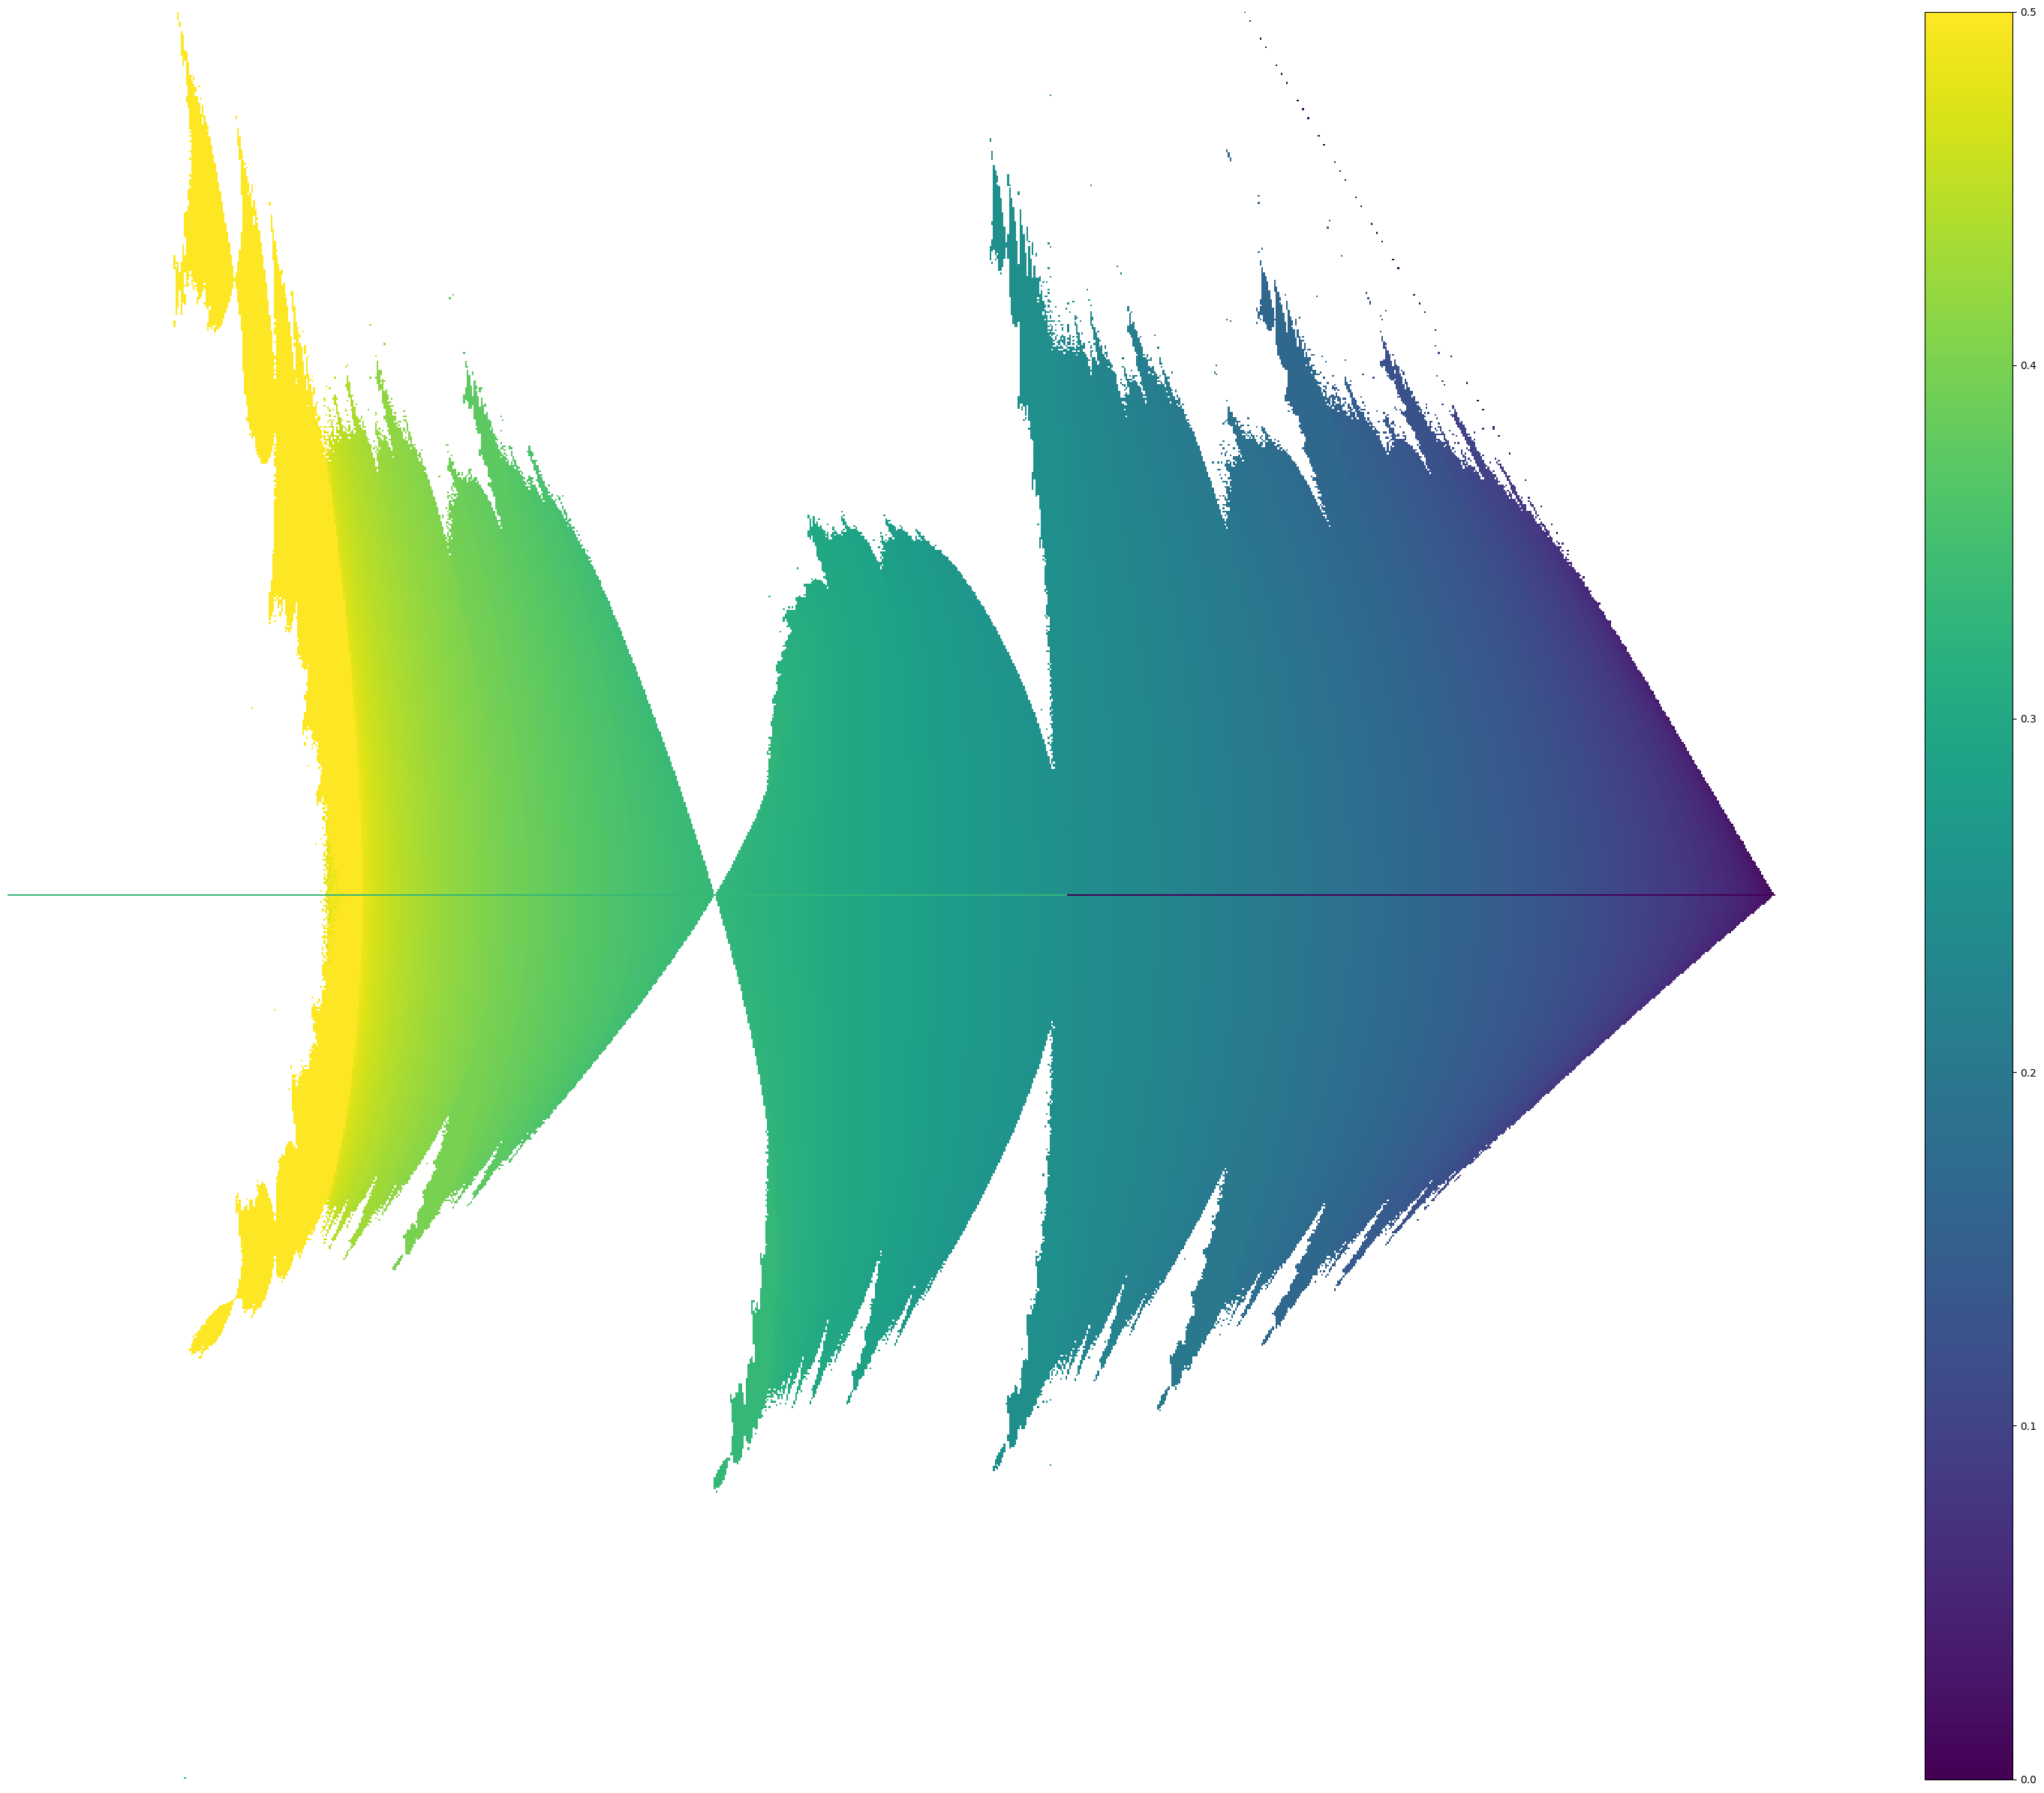

In [16]:
# Plot & save frequency results

# Set output file nane

frequency_file = 'frequency.dat'

# Plot frequencies color plot

plt.figure(figsize=(5*8, 3*8))
plt.imshow(out_fma[:, :, 0].T, vmin=0.0, vmax=0.5, aspect='equal', origin='lower', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.savefig('frequency.png', dpi=200)
plt.show()

# Save data

nan = 1.0
out = numpy.nan_to_num(out_fma[:, :, 0].T.flatten(), nan=nan)
out.astype('float64').tofile(frequency_file)

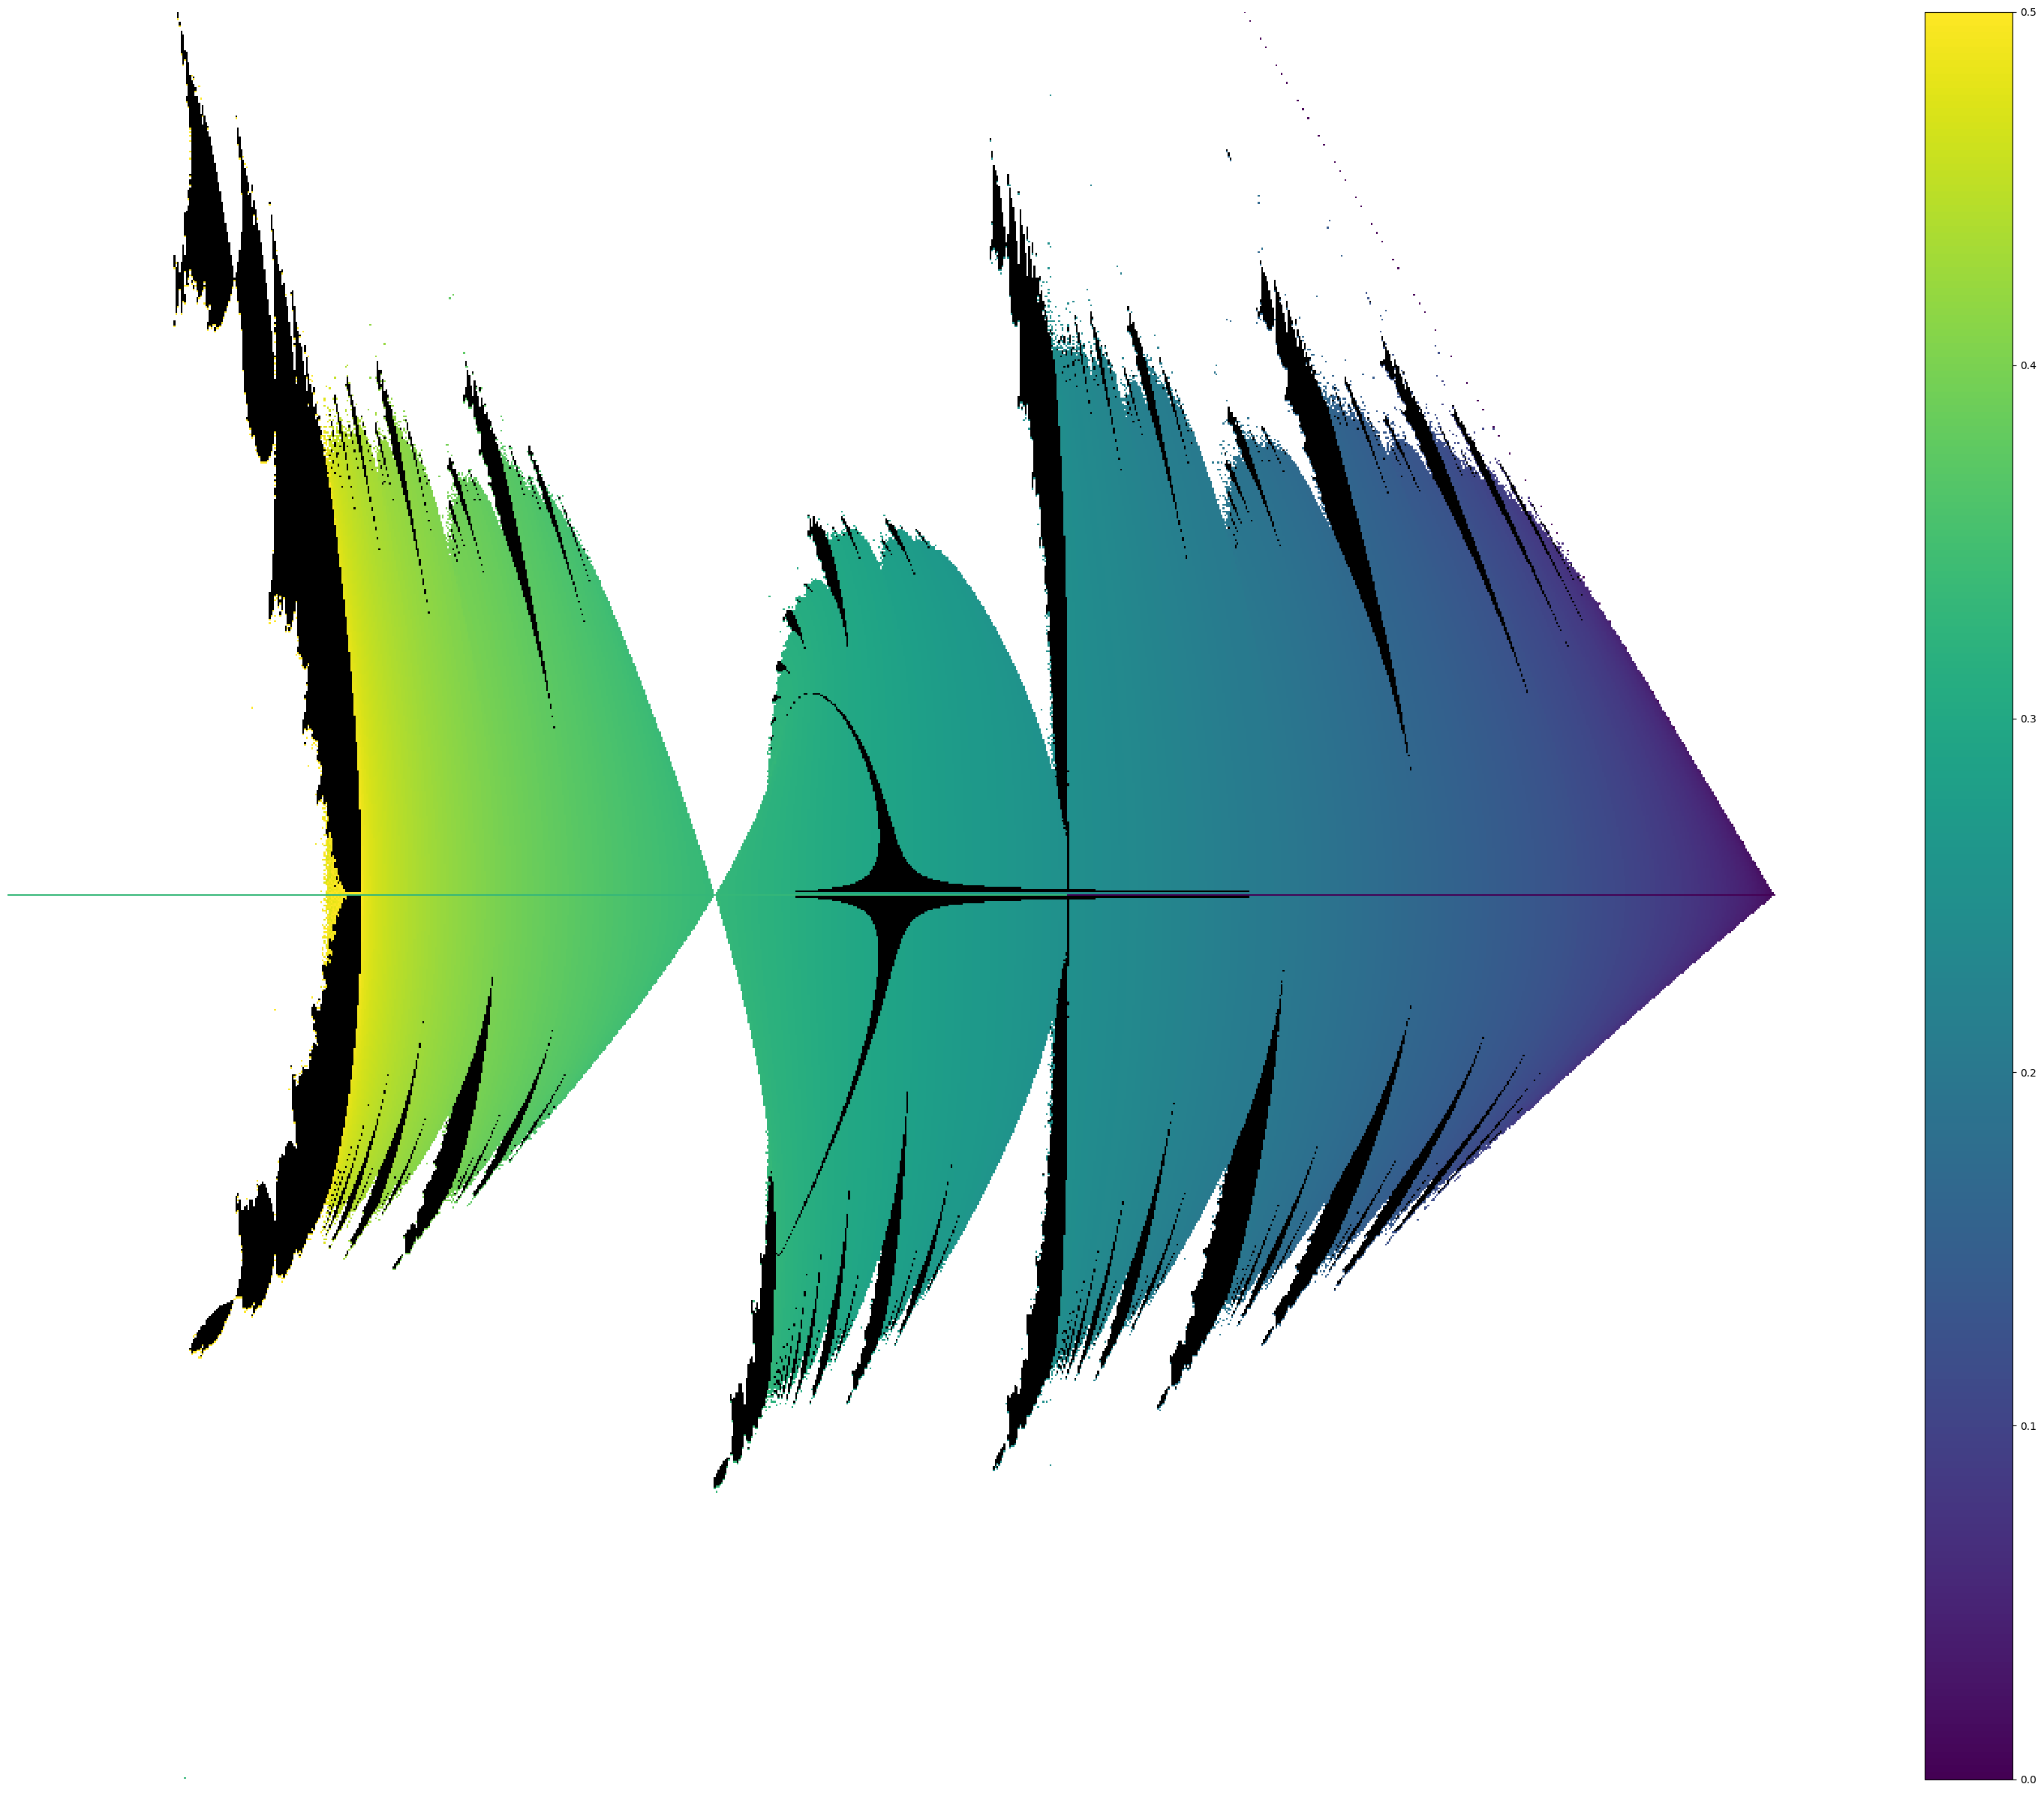

In [17]:
# Highligt mode locked regions in frequency space

# Set output file nane

tongues_file = 'tongues_file.dat'

# Process data

# Set close frequencies and replace value

error = 1.0E-6
value = -1.0

data = tongues(1.0E-6, -1.0, out_fma[:, :, 0]).T

# Set cmap to highlight under (can be used with upper)

cmap = colormaps['viridis']
cmap.set_under(color='black')

# Plot

plt.figure(figsize=(5*8, 3*8))
plt.imshow(data, vmin=0.0, vmax=0.5, aspect='equal', origin='lower', cmap=cmap, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.savefig('tongues.png', dpi=200)
plt.show()

# Save data

# Note, +1.0 -- nan, -1.0 -- locked

nan = 1.0
out = numpy.nan_to_num(data.flatten(), nan=nan)
out.astype('float64').tofile(tongues_file)

1002001
308598


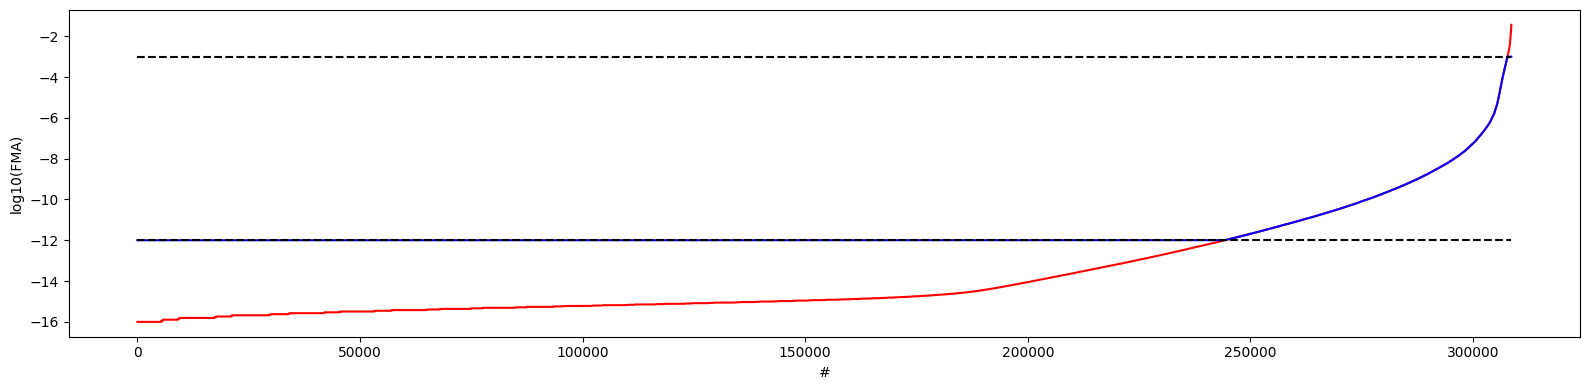

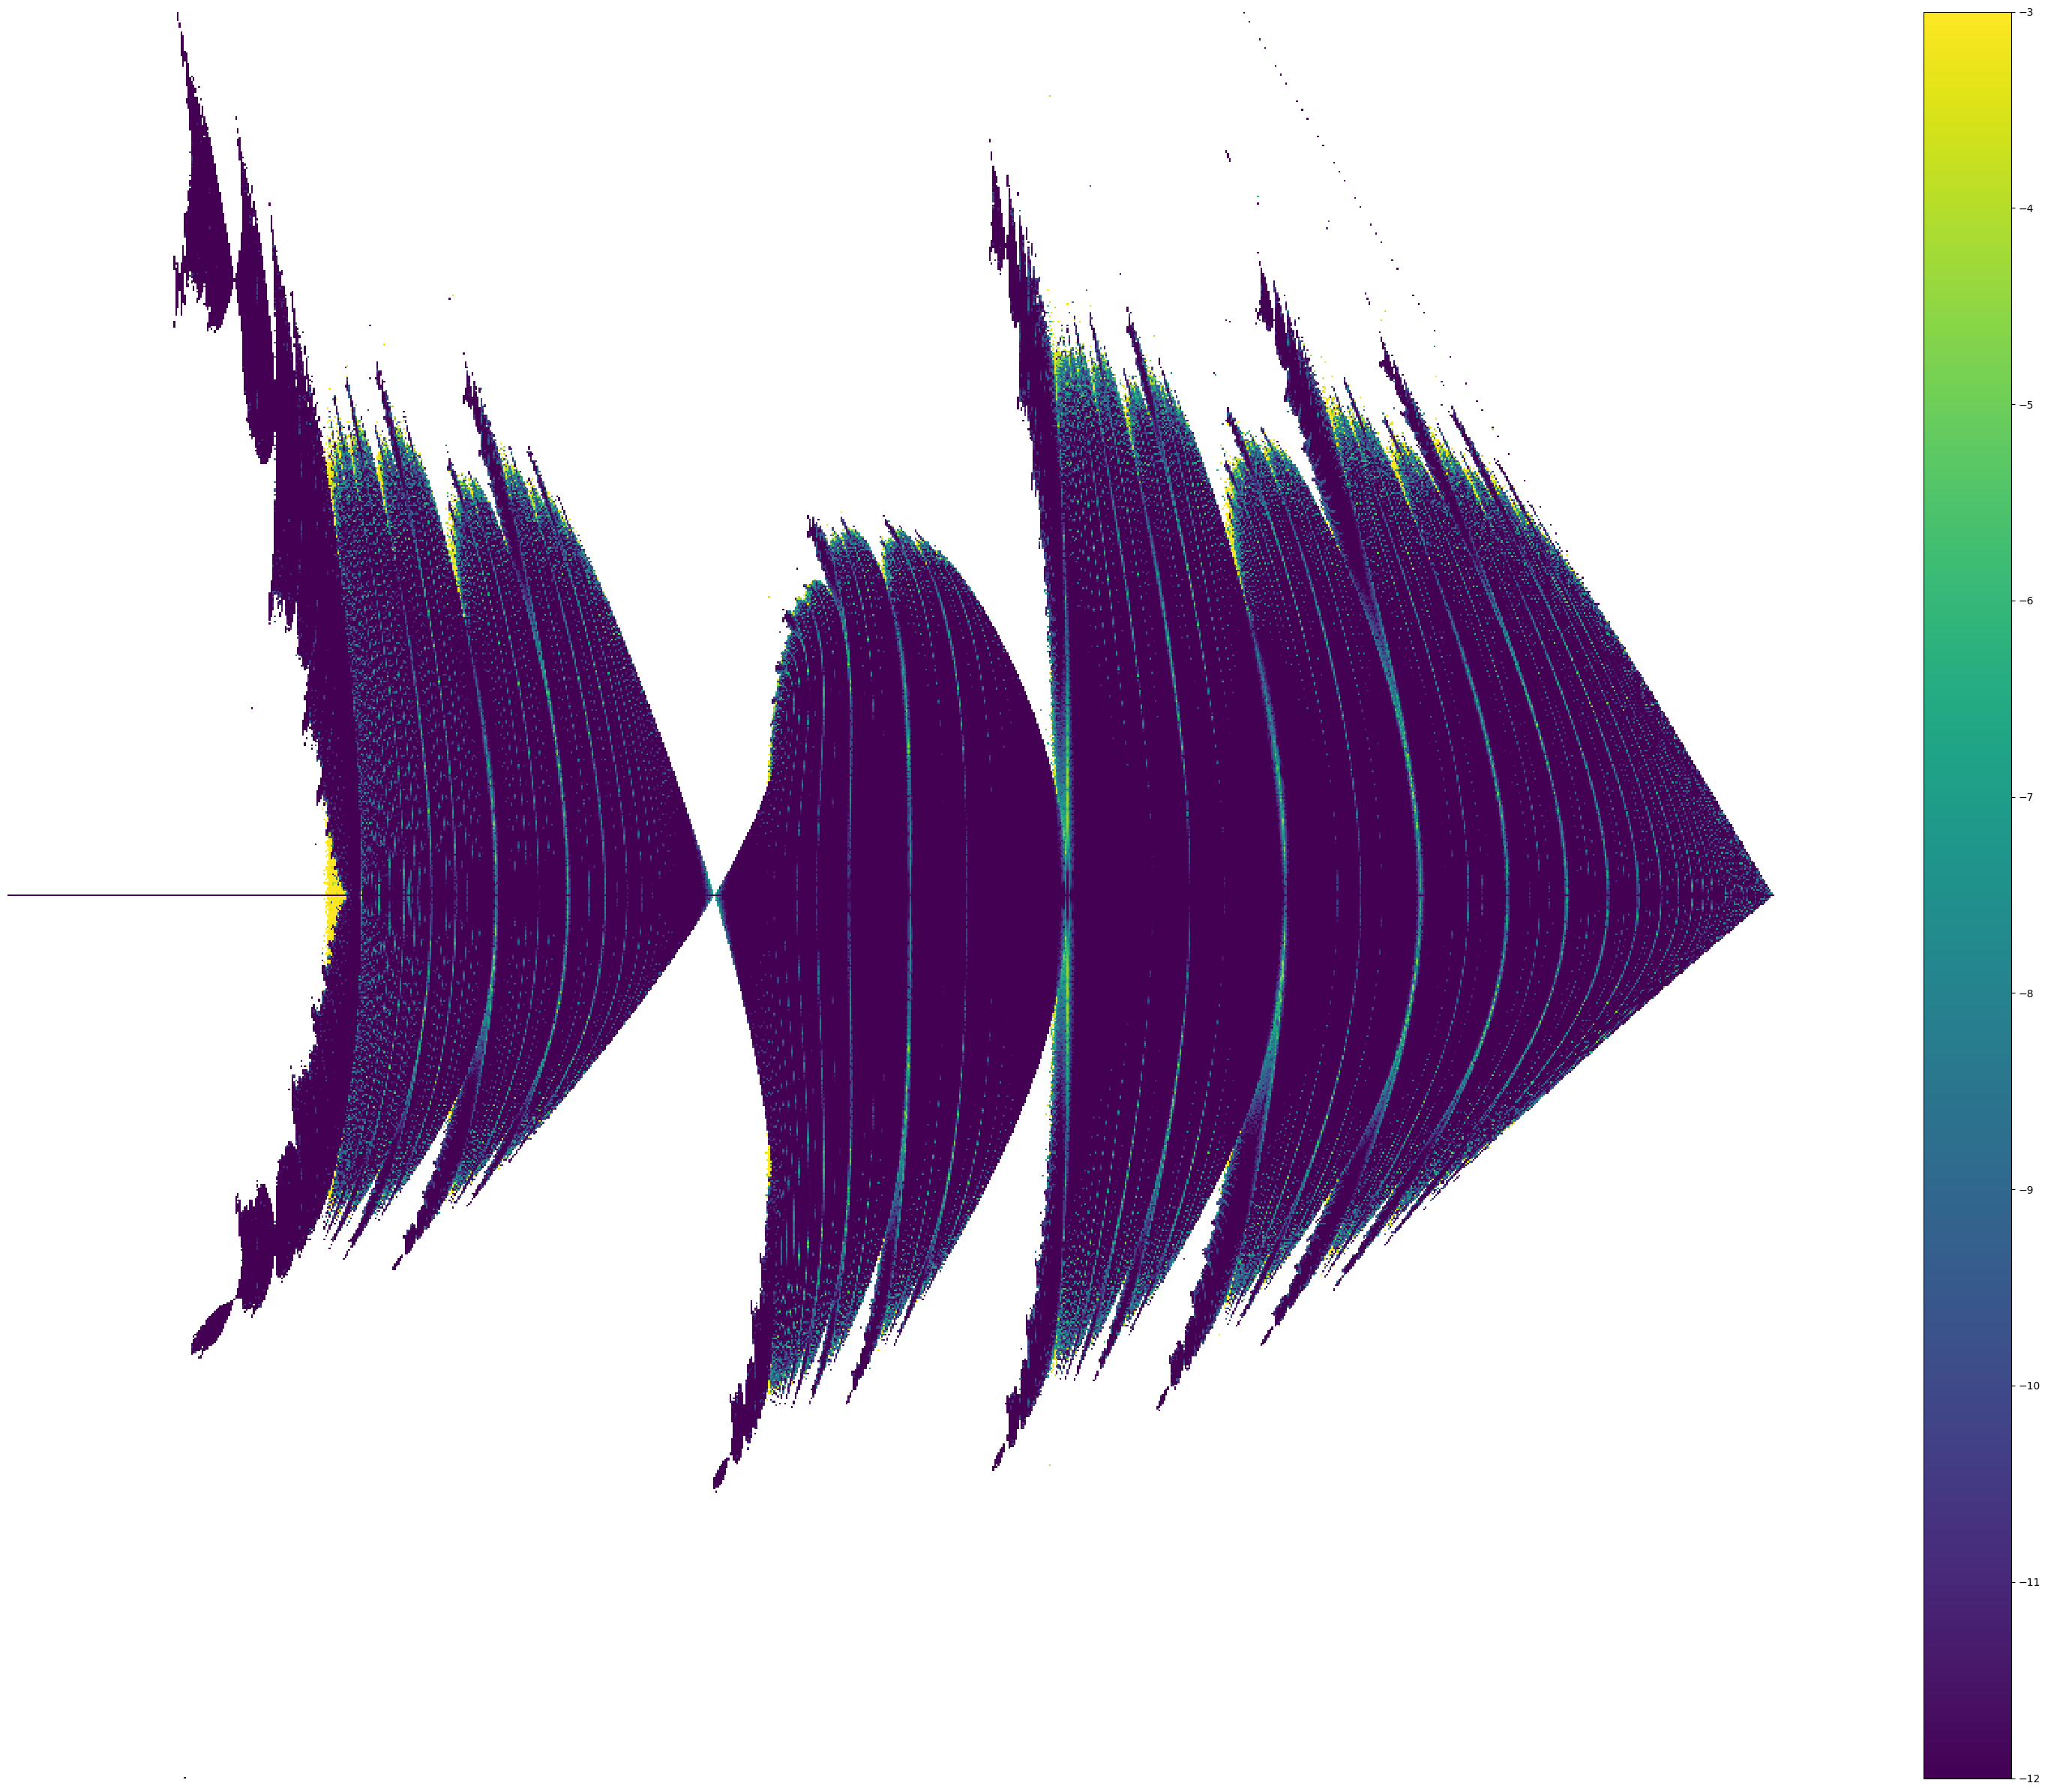

In [18]:
# Plot & save FMA results

# Set output file nane

fma_file = 'fma.dat'

# Sorted FMA values

elbow = numpy.nan_to_num(numpy.log10(1.0E-16 + numpy.sqrt((out_fma[:, :, 0] - out_fma[:, :, 1])**2)).flatten(), nan=100.0)
print(len(elbow))

# Remove replaced nan values
# Note, number of 'survived' initials is expected to be less than for the REM case, since number iterations is doubles

elbow = elbow[elbow!= 100.0]
print(len(elbow))

# Plot elbow (winsorized to [-12, -3] interval )

# Note, the elbow is less sharp compared to REM case
# In seems to have three parts
# FMA is (comparativly more) sensitive to resonances

plt.figure(figsize=(16, 4))
plt.plot(numpy.sort(elbow), color='red')
elbow[elbow <= -12.0] = -12.0
elbow[elbow == 100.0] = -100.0
elbow[elbow >= -3.0] = -3.0
elbow[elbow == -100.0] = float('nan')
plt.plot(numpy.sort(elbow), color='blue')
plt.xlabel('#')
plt.ylabel('log10(FMA)')
plt.hlines(-12.0, 0, len(elbow), color='black', linestyles='dashed')
plt.hlines(-3.0, 0, len(elbow), color='black', linestyles='dashed')
plt.tight_layout()
plt.savefig('fma_elbow.png', dpi=200)
plt.show()

# Plot FMA color plot

# Winsorize data

out = numpy.nan_to_num(numpy.log10(1.0E-16 + numpy.sqrt((out_fma[:, :, 0] - out_fma[:, :, 1])**2)), nan=100.0)
out[out <= -12.0] = -12.0
out[out == 100.0] = -100.0
out[out >= -3.0] = -3.0
out[out == -100.0] = float('nan')

plt.figure(figsize=(5*8, 3*8))
plt.imshow(out.T, vmin=-12.0, vmax=-3.0, aspect='equal', origin='lower', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.savefig('fma.png', dpi=200)
plt.show()

# Save data

nan = 1.0
out = numpy.nan_to_num(numpy.log10(1.0E-16 + numpy.sqrt((out_fma[:, :, 0] - out_fma[:, :, 1])**2)).T.flatten(), nan=nan)
out.astype('float64').tofile(fma_file)

# Example-02: Load to Wolfram Mathematica

In [1]:
(* This requires Wolfram Language kernel to run in Jupyter or just run in WM *)
(* See, https://github.com/WolframResearch/WolframLanguageForJupyter *)

In [3]:
size = 1001 ;
data = ArrayReshape[BinaryReadList["rem.dat", "Real64"], {size, size}] ;
data // Dimensions

{1001, 1001}

# Phase space coverage by lines

# Elbow convergence vs number of iterations

# Quadratic

# Cubic

# Chirikov